In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


Menyiapkan Direktori

In [ ]:
base_dir = '/content/drive/My Drive/Diskriminasi1/'
!ls "/content/drive/My Drive/Diskriminasi1/"

bahan  latih  model  test  validasi


In [ ]:
#menentukan direktori
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')


In [ ]:
#menentukan direktori isi bahan
babi_dir = os.path.join(bahan_dir, 'babi/')
sapi_dir = os.path.join(bahan_dir, 'sapi/')

print("Jumlah data train tiap kelas")
print("Jumlah citra kulit babi  :", len(os.listdir(babi_dir)))
print("Jumlah citra kulit sapi  :", len(os.listdir(sapi_dir)))

Jumlah data train tiap kelas
Jumlah citra kulit babi  : 100
Jumlah citra kulit sapi  : 100


In [ ]:
#Direktori isi latih/training
train_babi = os.path.join(train_dir, 'babi/')
train_sapi = os.path.join(train_dir, 'sapi/')

#Direktori isi validasi
validation_babi = os.path.join(validation_dir, 'babi/')
validation_sapi = os.path.join(validation_dir, 'sapi/')


Menyiapkan Dataset

In [ ]:
import random
from shutil import copyfile


def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

#jumlah pembagian data training dan validasi
train_ratio = 0.8

#pembagian training dan validasi
#training
source_00 = babi_dir
train_00 = train_babi
val_00 = validation_babi
train_val_split(source_00, train_00, val_00, train_ratio)

#validasi
source_01 = sapi_dir
train_01 = train_sapi
val_01 = validation_sapi
train_val_split(source_01, train_01, val_01, train_ratio)

In [ ]:
print('Jumlah Semua Babi  :', len(os.listdir(babi_dir)))
print('Jumlah Train Babi  :', len(os.listdir(train_babi)))
print('Jumlah Val Babi    :', len(os.listdir(validation_babi)))

Jumlah Semua Babi  : 100
Jumlah Train Babi  : 80
Jumlah Val Babi    : 20


Pre Processing


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

Target

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'binary'
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

Model CNN

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (150, 150,3)),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Flatten(),
          #tf.keras.layers.Dense(200, activation = 'relu'),
          #tf.keras.layers.Dropout(0.3,seed=112),
          tf.keras.layers.Dense(512, activation = 'relu'),
          #tf.keras.layers.Dropout(0.5,seed=112),
          tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
import keras as tf
# define the checkpoint
checkpoint_filepath = "/content/drive/My Drive/Diskriminasi1/model/kulitbabi-kulitsapi-{epoch:02d}-{accuracy:.4f}-{val_accuracy:.4f}.h5"
model_checkpoint_callback = tf.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = False,
    monitor = 'accuracy',
    mode = 'max',
    save_best_only = True)

history = model.fit(
            train_generator,
            steps_per_epoch = 16,
            epochs = 10,
            validation_data = val_generator,
            validation_steps = 2,
            verbose = 1,
            callbacks = [model_checkpoint_callback])

Epoch 1/10
16/16 [==============================] - 8s 474ms/step - loss: 0.6636 - accuracy: 0.5813 - val_loss: 0.8208 - val_accuracy: 0.4000
Epoch 2/10
16/16 [==============================] - 8s 481ms/step - loss: 0.5792 - accuracy: 0.7437 - val_loss: 0.5346 - val_accuracy: 0.8000
Epoch 3/10
16/16 [==============================] - 8s 471ms/step - loss: 0.4679 - accuracy: 0.8313 - val_loss: 0.4482 - val_accuracy: 0.9000
Epoch 4/10
16/16 [==============================] - 7s 445ms/step - loss: 0.3715 - accuracy: 0.8625 - val_loss: 0.3614 - val_accuracy: 0.8000
Epoch 5/10
16/16 [==============================] - 8s 470ms/step - loss: 0.2764 - accuracy: 0.9187 - val_loss: 0.4093 - val_accuracy: 0.8000
Epoch 6/10
16/16 [==============================] - 7s 463ms/step - loss: 0.2256 - accuracy: 0.9375 - val_loss: 0.3605 - val_accuracy: 0.8000
Epoch 7/10
16/16 [==============================] - 7s 438ms/step - loss: 0.1826 - accuracy: 0.9625 - val_loss: 0.1397 - val_accuracy: 0.9500
Epoch 

Tingkat akurasi dan loss model

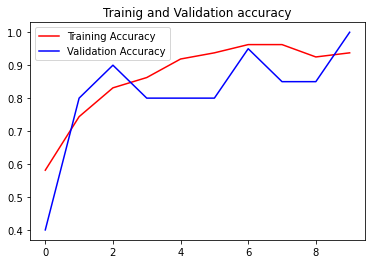

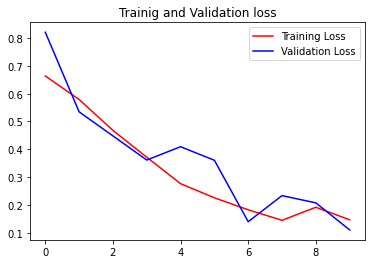

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Trainig and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Trainig and Validation loss')
plt.legend(loc = 'best')
plt.show()

**Pengujian**

load model

In [ ]:
from tensorflow.keras.models import load_model

DIR = "/content/drive/My Drive/Diskriminasi1/model/"
model = load_model(DIR+"kulitbabi-kulitsapi-07-0.9625-0.9500.h5")


prediksi

Saving kulit kuda 02.png to kulit kuda 02.png
[0.]
This image belongs to class Kulit Babi


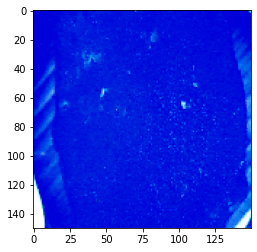

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
from termcolor import colored


uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150, 150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])
  if classes[0]>0.5:
    print(colored('This image belongs to class Kulit Sapi', attrs=['bold']))
  else:
    print(colored('This image belongs to class Kulit Babi', attrs=['bold']))